In [1]:
# check the necessary dependencies
from __future__ import print_function
#%matplotlib inline
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# check PyTorch version and cuda status
print(torch.__version__, torch.cuda.is_available())

# set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

2.5.0+cu124 True
Random Seed:  999


In [2]:
# root directory for dataset
dataroot = "data/celeba"

# number of workers for dataloader
workers = 2

# batch size during training
batch_size = 128

# spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# number of channels in the training images. For color images this is 3
nc = 3

# size of z latent vector (i.e. size of generator input)
nz = 100

# size of feature maps in generator
ngf = 64

# size of feature maps in discriminator
ndf = 64

# number of training epochs (to save time, we only train for 3 epochs in this tutorial)
# num_epochs = 3
num_epochs = 5

# learning rate for optimizers
lr = 0.0002

# beta1 hyperparam for Adam optimizers
beta1 = 0.5

# number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [3]:
# generator code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution. nz x 1 x 1
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [8]:
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# 创建生成器
netG = Generator(ngpu).to(device)

# 多GPU的情况
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

netG.load_state_dict(torch.load('./checkpoint/dcgan_checkpoint.pth', weights_only=False))

# 查看模型的具体结构
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


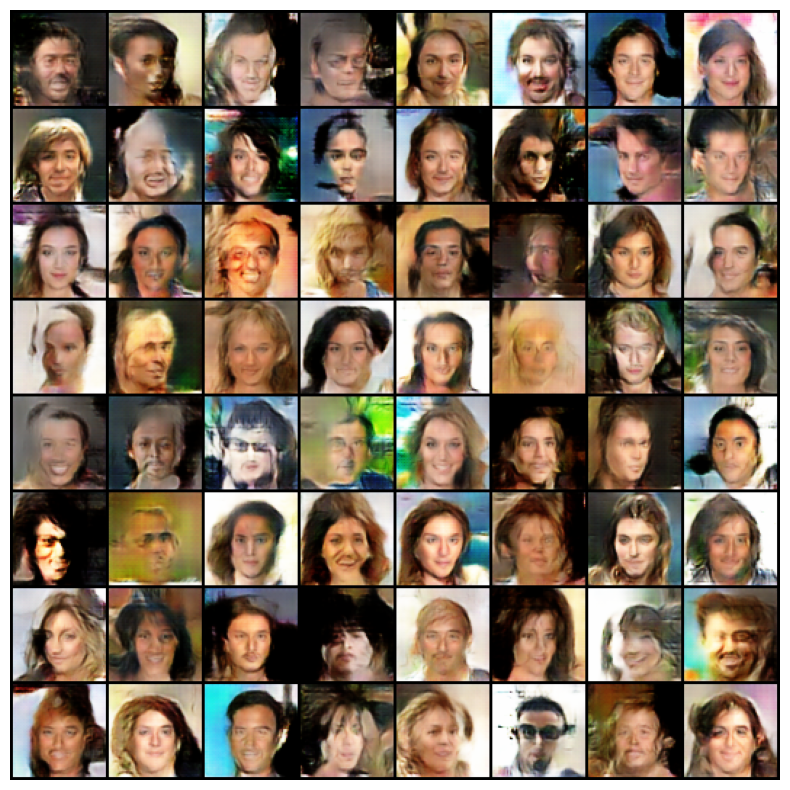

In [11]:
# 第一步：生成64个随机噪声向量
num_samples = 64
nz = 100  # 潜在向量z的维度大小
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
noise = torch.randn(num_samples, nz, 1, 1, device=device)

# 使用生成器生成对应的图像
with torch.no_grad():
    fake_images = netG(noise).detach().cpu()
grid = vutils.make_grid(fake_images, padding=2, normalize=True)
plt.figure(figsize=(10, 10))
plt.imshow(np.transpose(grid, (1, 2, 0)))
plt.axis("off")
plt.show()

In [12]:
# 第二步：选择具有相反属性的图像，并获取其噪声向量
# 例如，indices_pos是具有属性+A的图像索引
# indices_neg是具有属性-A的图像索引
indices_pos = [36, 10, 49, 32]  # 替换为实际的索引
indices_neg = [27, 28, 29, 30]  # 替换为实际的索引

noise_pos = noise[indices_pos]
noise_neg = noise[indices_neg]

In [13]:
vA = noise_pos.mean(dim = 0) - noise_neg.mean(dim = 0)
torch.save(vA, 'smile.pt')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.9974555].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99999994..0.9988383].


Text(0.5, 1.0, 'Edited Image')

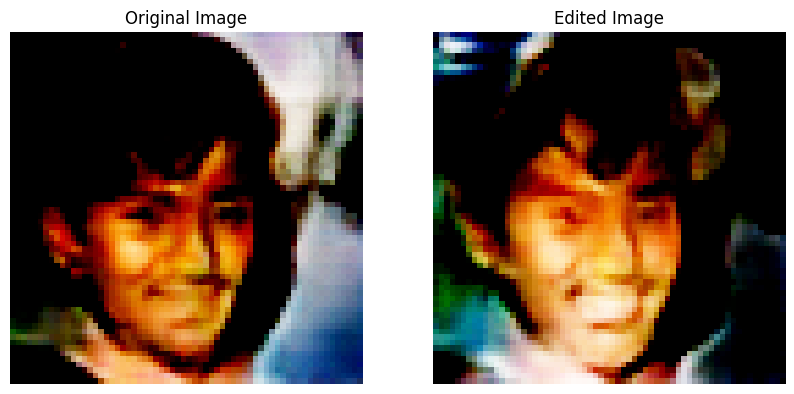

In [16]:
z = torch.randn(1, nz, 1, 1, device=device)
edited_z = z + vA.unsqueeze(0)

with torch.no_grad():
    image_z = netG(z).detach().cpu()
    image_edited_z = netG(edited_z).detach().cpu()

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(np.transpose(image_z[0], (1, 2, 0)))
plt.axis("off")
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(np.transpose(image_edited_z[0], (1, 2, 0)))
plt.axis("off")
plt.title("Edited Image")
